In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.cross_validation import train_test_split
import random
from sklearn.metrics import log_loss
from math import exp
import xgboost as xgb
from XGBoostPackage import xgbClass
from CrossValidation import CVScore
# from difflib import SequenceMatcher
import editdistance

%matplotlib inline

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
random.seed(321)
np.random.seed(321)

X_train = pd.read_json("../input/train.json")
X_test = pd.read_json("../input/test.json")

dfSentiment=pd.read_csv("sentimentFeatureAdded.csv")
#print(dfSentiment.shape)
dfSentiment['manager_id']=X_train['manager_id']
dfSentimentTest=pd.read_csv("sentimentFeatureAddedTest.csv")
#print(dfSentiment.shape)
dfSentimentTest['manager_id']=X_test['manager_id']
dmean=pd.DataFrame()
for i in ['neg','neu','pos']:
    dmean[i]=pd.concat([dfSentiment,dfSentimentTest]).groupby('manager_id')[i].mean()
dfSentiment.fillna(dmean)
dfSentimentTest.fillna(dmean)
for i in ['neg','neu','pos']:
    X_train[i]=dfSentiment[i]
    X_test[i]=dfSentimentTest[i]

In [3]:
interest_level_map = {'low': 0, 'medium': 1, 'high': 2}
X_train['interest_level'] = X_train['interest_level'].apply(lambda x: interest_level_map[x])
X_test['interest_level'] = -1
X_train['features'] = X_train["features"].apply(lambda x: " ".join(["_".join(i.strip().lower().split(" ")) for i in x]))
X_test['features'] = X_test["features"].apply(lambda x: " ".join(["_".join(i.strip().lower().split(" ")) for i in x]))
X_train['price'].ix[X_train['price']>13000] = 13000

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [4]:
def clean(x):
#     x = s.replace("-", "")
#     x = x.replace(" ", "")
#     x = x.replace("twenty_four_hour", "24")
#     x = x.replace("24/7", "24")
#     x = x.replace("24hr", "24")
#     x = x.replace("24-hour", "24")
#     x = x.replace("24hour", "24")
#     x = x.replace("24 hour", "24")
    for i in ['24_hour_concierge/doorman','24/7_doorman_concierge',
              '24-hour_doorman',
              '24/7_concierge',
              '24/7_doorman',
              '24hr_doorman']+['24_hour_doorman']\
    +['twenty-four_hour_concierge_and_doorman'\
             ,'time_doorman','full-time_doorman','ft_doorman']:
        x = x.replace(i, '24hr_doorman')
    #x = x.replace("common", "cm")
    for i in ['cable/satellite_tv', 'cable_ready']:
        x = x.replace(i, 'cable')
    for i in ["children's_playroom",
#               'children\xe2\x80\x99s_playroom',
              'childrens_playroom']:
        x = x.replace(i, "children's_playroom")
    #x = x.replace("concierge", "doorman")
    #x = x.replace("bicycle", "bike")
    for i in ['bicycle_room', 'bike_room', 'bike_storage']:
        x = x.replace(i, 'bike_room')
    for i in ['billiards_room',
              'billiards_table_and_wet_bar']:
        x = x.replace(i, 'billiards')
    for i in ['concierge_service', 'concierge', 'doorman_service', 'doorman'
             ]:
        x = x.replace(i, 'doorman')
    #x = x.replace("private", "pv")
    #x = x.replace("deco", "dc")
    #x = x.replace("decorative", "dc")
    x = x.replace('deco_brick_walls', 'deco_brick_wall')
    x = x.replace('decorative_fireplace','deco_fireplace')
    x = x.replace('dish_washer', 'dishwasher')
    x = x.replace('_exposed_brick_','exposed_brick')
    #x = x.replace("onsite", "os")
    #x = x.replace("outdoor", "od")
    for i in ['fitness_center', 'fitness_facility', 'fitness_room']\
    +['gym/fitness','gym_in_building']:
        x = x.replace(i, 'gym')
    x = x.replace('fireplaces','fireplace')
    for i in ['eat-in_kitchen'\
             ,'in_kitchen_', 'in_kitchen','eat_in_kitchen','s_kitchen_','_kitchen_'\
             ,'eat_kitchen'\
             ,'_skitchen']:
        x = x.replace(i,'kitchen')
#     x = x.replace("ft","full-time")
    for i in ['granite_countertops',
              'granite_counter_tops',
              'granite_counters',
              'granite_counter',
              'granite_kitchen']:
        x = x.replace(i, 'granite')
    for i in ['hardwood_floors','hardwood_floor']:
        x = x.replace(i, 'hardwood')
    x = x.replace('high_ceilings','high_ceiling')
    for i in ['high-speed_internet',
#               'high_floor',
#              'high_speed_internet',
              'high_speed_internet_available']:
#               'highrise']:
        x = x.replace(i, 'high_speed_internet')
    x = x.replace('large_living-room', 'large_living_room')
    x = x.replace('laundry_on_every_floor','laundry_on_floor')
    x = x.replace('marble_bathroom','marble_bath')
    x = x.replace('media_screening_room','media_room')
    x = x.replace('multi-level', 'multi_level')
    for i in ['parking_space','on-site_parking',
              'on-site_parking_available',
              'parking_available',
              'on-site_parking_lot']\
    :
        x = x.replace(i, 'parking')
    for i in ['pets:_cats/small_dogs',
              'pets_allowed',
              #'cats_allowed','dogs_allowed',
              'pets_on_approval']\
    +['all_pets_ok','_pets_ok_','pet_friendly']\
    :
        x = x.replace(i, 'pets')
    for i in ['pre_war']+['pre-war', 'prewar', 'pre']:
        x = x.replace(i, 'pre')
    for i in ['post-war', 'post_war', 'postwar', 'post']:
        x = x.replace(i, 'post')
    x = x.replace('publicoutdoor','outdoor')
    for i in ['common_roof_deck','common_roof',
              'roof-deck',
              'roof_access',
              'roof_decks',
              'roof_deck',
              #'roof_deck_with_grills',
              'rooftop_deck',
              'roofdeck',
              'rooftop_terrace',
              'rooftop']:
        x = x.replace(i,'roof')
    x = x.replace('shares_ok','share_ok')
    for i in ["ss appliances", 
              'stainless_steel_appliances',
              'stainless_steel_kitchen',
             'stainless_steel']:
        x = x.replace(i, "stainless")
    for i in ['storage_available',
              'storage_facilities_available',
              'storage_room',
              'storage_space']:
        x = x.replace(i, 'storage')
    for i in ['super_on-site', 'on-site_super']+['live-in_super',
              'live-in_superintendent',
              'live/work',
              'live_in_super','site_super','superintendent']:
        x = x.replace(i, 'super')
    x.replace('swimming_pool', 'pool')
    for i in ['valet_laundry',
#               'valet_parking',
              'valet_services',
              #'valet_services_(housekeeping/dry_cleaning_available)',
              'valet_services_including_dry_cleaning',
              #'laundry_&_housekeeping',
              'valet_service']:
        x = x.replace(i, 'valet')
    for i in ['washer/dryer_in-unit','washer_in_unit', 'laundry_in_unit','dryer_in_unit']:
        x = x.replace(i,'washer_in_unit')    
    for i in [#'walk-up',
#              'walk_in_closet',
              'walk_in_closet(s)',
              'closet_space',
              'walk-in_closet',
             ]:
        x = x.replace(i, 'closet')
    for i in ['dry_cleaning_service',
              'washer/dryer_hookup',
              'washer/dryer_in_bldg',
              'washer/dryer_in_building',              
              'washer_&_dryer','laundry_in_building','laundry_room',
              'site_laundry','_washer','dryer']:
        x = x.replace(i, 'laundry')
    x = x.replace('wheelchair_ramp', 'wheelchair_access')
    for i in ['wi-fi_access',
              'wifi_access',
              'wifi_in_resident_lounge'\
    #,'free_wifi', 'free_wifi_in_club_lounge'\
    ]:
        x = x.replace(i, 'wifi')
    return x

In [5]:
print(X_train.shape)
X_train['features']=X_train['features'].apply(clean)
X_test['features']=X_test['features'].apply(clean)
X_train.head(1)

(49352, 18)


,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address,neg,neu,pos
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,,1,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,0.0,0.864,0.136


In [6]:
# X_train['features'].head(20)

In [7]:
#add features
feature_transform = CountVectorizer(stop_words='english', max_features=120)
# X_train['features'] = X_train["features"].apply(lambda x: " ".join(["_".join(i.lower().split(" ")) for i in x]))
# X_test['features'] = X_test["features"].apply(lambda x: " ".join(["_".join(i.lower().split(" ")) for i in x]))
feature_transform.fit(list(X_train['features']) + list(X_test['features']))

train_size = len(X_train)
low_count = len(X_train[X_train['interest_level'] == 0])
medium_count = len(X_train[X_train['interest_level'] == 1])
high_count = len(X_train[X_train['interest_level'] == 2])

In [8]:
def find_objects_with_only_one_record(feature_name):
    temp = pd.concat([X_train[feature_name].reset_index(), 
                      X_test[feature_name].reset_index()])
    temp = temp.groupby(feature_name, as_index = False).count()
    return temp[temp['index'] == 1]

managers_with_one_lot = find_objects_with_only_one_record('manager_id')
buildings_with_one_lot = find_objects_with_only_one_record('building_id')
addresses_with_one_lot = find_objects_with_only_one_record('display_address')


In [9]:
lambda_val = None
k=5.0
f=1.0
r_k=0.01 
g = 1.0
def categorical_average(variable, y, pred_0, feature_name):
    def calculate_average(sub1, sub2):
        s = pd.DataFrame(data = {
                                 variable: sub1.groupby(variable, as_index = False).count()[variable],                              
                                 'sumy': sub1.groupby(variable, as_index = False).sum()['y'],
                                 'avgY': sub1.groupby(variable, as_index = False).mean()['y'],
                                 'cnt': sub1.groupby(variable, as_index = False).count()['y']
                                 })
                                 
        tmp = sub2.merge(s.reset_index(), how='left', left_on=variable, right_on=variable) 
        del tmp['index']                       
        tmp.loc[pd.isnull(tmp['cnt']), 'cnt'] = 0.0
        tmp.loc[pd.isnull(tmp['cnt']), 'sumy'] = 0.0

        def compute_beta(row):
            cnt = row['cnt'] if row['cnt'] < 200 else float('inf')
            return 1.0 / (g + exp((cnt - k) / f))
            
        if lambda_val is not None:
            tmp['beta'] = lambda_val
        else:
            tmp['beta'] = tmp.apply(compute_beta, axis = 1)
            
        tmp['adj_avg'] = tmp.apply(lambda row: (1.0 - row['beta']) * row['avgY'] + row['beta'] * row['pred_0'],
                                   axis = 1)
                                   
        tmp.loc[pd.isnull(tmp['avgY']), 'avgY'] = tmp.loc[pd.isnull(tmp['avgY']), 'pred_0']
        tmp.loc[pd.isnull(tmp['adj_avg']), 'adj_avg'] = tmp.loc[pd.isnull(tmp['adj_avg']), 'pred_0']
        tmp['random'] = np.random.uniform(size = len(tmp))
        tmp['adj_avg'] = tmp.apply(lambda row: row['adj_avg'] *(1 + (row['random'] - 0.5) * r_k),
                                   axis = 1)
    
        return tmp['adj_avg'].ravel()
     
    #cv for training set 
    k_fold = StratifiedKFold(5)
    X_train[feature_name] = -999 
    for (train_index, cv_index) in k_fold.split(np.zeros(len(X_train)),
                                                X_train['interest_level'].ravel()):
        sub = pd.DataFrame(data = {variable: X_train[variable],
                                   'y': X_train[y],
                                   'pred_0': X_train[pred_0]})
            
        sub1 = sub.iloc[train_index]        
        sub2 = sub.iloc[cv_index]
        
        X_train.loc[cv_index, feature_name] = calculate_average(sub1, sub2)
    
    #for test set
    sub1 = pd.DataFrame(data = {variable: X_train[variable],
                                'y': X_train[y],
                                'pred_0': X_train[pred_0]})
    sub2 = pd.DataFrame(data = {variable: X_test[variable],
                                'y': X_test[y],
                                'pred_0': X_test[pred_0]})
    X_test.loc[:, feature_name] = calculate_average(sub1, sub2)                               



In [10]:
def transform_data(X):
    #add features    
    feat_sparse = feature_transform.transform(X["features"])
    vocabulary = feature_transform.vocabulary_
    del X['features']
    X1 = pd.DataFrame([ pd.Series(feat_sparse[i].toarray().ravel()) for i in np.arange(feat_sparse.shape[0]) ])
    X1.columns = list(sorted(vocabulary.keys()))
    X = pd.concat([X.reset_index(), X1.reset_index()], axis = 1)
    del X['index']
    
    X["num_photos"] = X["photos"].apply(len)
    X['created'] = pd.to_datetime(X["created"])
    X["num_description_words"] = X["description"].apply(lambda x: len(x.split(" ")))
    X['price_per_bed'] = X['price'] / X['bedrooms']    
    X['price_per_bath'] = X['price'] / X['bathrooms']
    X['price_per_room'] = X['price'] / (X['bathrooms'] + X['bedrooms'] )
    
    X['low'] = 0
    X.loc[X['interest_level'] == 0, 'low'] = 1
    X['medium'] = 0
    X.loc[X['interest_level'] == 1, 'medium'] = 1
    X['high'] = 0
    X.loc[X['interest_level'] == 2, 'high'] = 1
    
    X['display_address'] = X['display_address'].apply(lambda x: x.lower().strip())
    X['street_address'] = X['street_address'].apply(lambda x: x.lower().strip())
#     def similar(a, b):
#         return SequenceMatcher(None, a, b).ratio()
#     X['display_street_dist']=X.apply(lambda row: similar(row['display_address'], row['street_address']), axis=1)
    X['display_street_dist']=X.apply(lambda row: editdistance.eval\
                                     (row['display_address'], row['street_address']), axis=1)
    
    X['pred0_low'] = low_count * 1.0 / train_size
    X['pred0_medium'] = medium_count * 1.0 / train_size
    X['pred0_high'] = high_count * 1.0 / train_size
    
    X.loc[X['manager_id'].isin(managers_with_one_lot['manager_id'].ravel()), 
          'manager_id'] = "-1"
    X.loc[X['building_id'].isin(buildings_with_one_lot['building_id'].ravel()), 
          'building_id'] = "-1"
    X.loc[X['display_address'].isin(addresses_with_one_lot['display_address'].ravel()), 
          'display_address'] = "-1"
          
    return X

def normalize_high_cordiality_data():
    high_cardinality = ["building_id", "manager_id"]
    for c in high_cardinality:
        categorical_average(c, "medium", "pred0_medium", c + "_mean_medium")
        categorical_average(c, "high", "pred0_high", c + "_mean_high")

def transform_categorical_data():
    categorical = ['building_id', 'manager_id', 
                   'display_address', 'street_address']
                   
    for f in categorical:
        encoder = LabelEncoder()
        encoder.fit(list(X_train[f]) + list(X_test[f])) 
        X_train[f] = encoder.transform(X_train[f].ravel())
        X_test[f] = encoder.transform(X_test[f].ravel())
                  

def remove_columns(X):
    columns = ["photos", "pred0_high", "pred0_low", "pred0_medium",
               "description", "low", "medium", "high",
               "interest_level", "created"]
    for c in columns:
        del X[c]

In [11]:
print("Starting transformations")        
X_train = transform_data(X_train)    
X_test = transform_data(X_test) 
y_train = X_train['interest_level'].ravel()

print("Normalizing high cordiality data...")
normalize_high_cordiality_data()
transform_categorical_data()




Starting transformations
Normalizing high cordiality data...


In [12]:
# (X_train['interest_level'])[(X_train['dogs_allowed']==1)&(X_train['cats_allowed']==1)]

In [13]:
# remove_columns(X_train)
# remove_columns(X_test)

In [14]:
print(X_train.shape)
X_train.head(2)

(49352, 153)


,bathrooms,bedrooms,building_id,created,description,display_address,interest_level,latitude,listing_id,longitude,...,medium,high,display_street_dist,pred0_low,pred0_medium,pred0_high,building_id_mean_medium,building_id_mean_high,manager_id_mean_medium,manager_id_mean_high
0,1.5,3,2103,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,10443,1,40.7145,7211212,-73.9425,...,1,0,4,0.694683,0.227529,0.077788,0.217575,7.436940e-02,0.283585,9.190504e-29
1,1.0,2,5077,2016-06-12 12:19:27,,7525,0,40.7947,7150865,-73.9667,...,0,0,4,0.694683,0.227529,0.077788,0.110642,1.761506e-07,0.012447,2.088626e-34


In [15]:
featuresInUse = [f for f in X_train.columns if f not in ["photos", "pred0_high", "pred0_low", "pred0_medium",
               "description", "low", "medium", "high",
               "interest_level", "created"]+['manager_id', 'building_id', "display_address"]\
                  #+['war','eat','on','building']                                       
                ]
                                                        #,'no_pets','_pets_ok_','bedrooms', 'dryer_in_unit',
                                                        #'health_club','common', 
#                  +list(imp.sort_values("train").head(10).index)]
#featuresInUse = [f for f in X_train.columns if f not in []]
len(featuresInUse)

140

In [46]:
#cross validation

X_fit, X_val, y_fit, y_val=train_test_split(X_train[featuresInUse][:], y_train[:], test_size=0.33, random_state=42)

In [47]:
param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.04
param['max_depth'] = 6
param['silent'] = 1
param['num_class'] = 3
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 3
param['subsample'] = 0.7
param['colsample_bytree'] = 0.7
param['seed'] = 42
param['nthread'] = 8
num_rounds = 1000


In [48]:
xgfit = xgb.DMatrix(X_fit, label=y_fit)
xgval = xgb.DMatrix(X_val, label=y_val)
watchlist = [ (xgfit,'train'), (xgval, 'test') ]
clfCV = xgb.train(param, xgfit, num_rounds)
#clfCV = xgb.train(param, xgfit, num_rounds, watchlist, early_stopping_rounds=20)

y_val_pred = clfCV.predict(xgval)
log_loss(y_val, y_val_pred)
#0.535112: 2000, f not in ['manager_id', 'building_id', "display_address"\,'common_roof_deck']]
#0.5355477 param['eta'] = 0.04param['max_depth'] = 6param['silent'] = 1param['subsample'] = 0.7param['colsample_bytree'] = 0.7
#param['seed'] = 42param['nthread'] = 8num_rounds = 1000 max_feature=120

0.53588101609378969

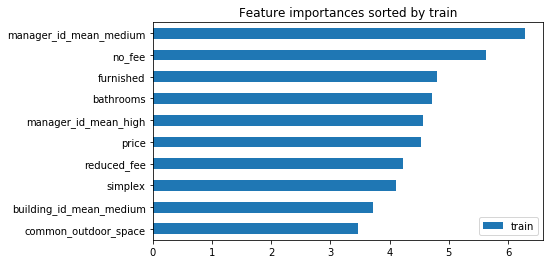

In [49]:
imp=pd.DataFrame()#(index=features_to_use)
imp['train'] = pd.Series(clfCV.get_score(importance_type='gain'))#, index=features_to_use)
imp = imp.fillna(0)
ax=imp.sort_values('train').tail(10).plot.barh(title='Feature importances sorted by train', figsize=(7,4))

In [50]:
print(len(imp))
imp.sort_values('train',ascending=False).head(45)

110


,train
manager_id_mean_medium,6.278254
no_fee,5.624382
furnished,4.802364
bathrooms,4.708242
manager_id_mean_high,4.564818
price,4.525262
reduced_fee,4.225683
simplex,4.106507
building_id_mean_medium,3.724258
common_outdoor_space,3.470265


In [51]:
imp.sort_values('train',ascending=False).tail(50)

,train
microwave,1.989773
pos,1.981045
sauna,1.978737
outdoor_areas,1.978534
neu,1.951365
dogs_allowed,1.928021
dining_room,1.903997
pre,1.889649
neg,1.886819
cats_allowed,1.873142


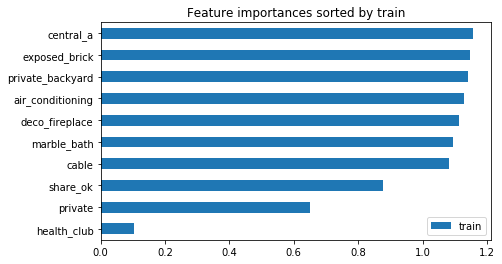

In [31]:
ax=imp.sort_values('train').head(10).plot.barh(title='Feature importances sorted by train', figsize=(7,4))

In [28]:
X_train[featuresInUse][:1]

,bathrooms,bedrooms,latitude,listing_id,longitude,price,street_address,24hr_doorman,_balconies,_chef,...,num_photos,num_description_words,price_per_bed,price_per_bath,price_per_room,display_street_dist,building_id_mean_medium,building_id_mean_high,manager_id_mean_medium,manager_id_mean_high
0,1.5,3,40.7145,7211212,-73.9425,3000,21630,0,0,0,...,5,95,1000.0,2000.0,666.666667,4,0.217575,0.074369,0.283585,9.190504e-29


In [ ]:
param_grid = {'eta':[.1, .04, .02], 'num_round':[500,1000], 'subsample':[.7], 'colsample_bytree':[.7], \
              'max_depth':[4,5, 6], 'seed':[2017]}
for eta in param_grid['eta']:
    for subsample in param_grid['subsample']:
        for colsample_bytree in param_grid['colsample_bytree']:
            for max_depth in param_grid['max_depth']:
                for seed in param_grid['seed']:
                    for num_rounds in param_grid['num_round']:
                        model=xgbClass(colsample_bytree=colsample_bytree, eta=eta, eva_metric='mlogloss', \
                                       subsample=subsample, max_depth=max_depth, seed=seed,\
                                       objective='multi:softprob', num_class=3,num_rounds=num_rounds)
                        score=CVScore(model=model, my_score=log_loss, X_train=(X_train[featuresInUse])[:],\
                                  y_train=y_train[:])
                        del model
                        print('eta={}, subsample={}, colsample_bytree={}, max_depth={}, seed={}, score={}, num_rounds={}'.\
                          format(eta, subsample, colsample_bytree, max_depth, seed, score, num_rounds))

eta=0.1, subsample=0.7, colsample_bytree=0.7, max_depth=4, seed=2017, score=0.536643483134, num_rounds=500
eta=0.1, subsample=0.7, colsample_bytree=0.7, max_depth=4, seed=2017, score=0.53880697507, num_rounds=1000
eta=0.1, subsample=0.7, colsample_bytree=0.7, max_depth=5, seed=2017, score=0.536014010872, num_rounds=500
eta=0.1, subsample=0.7, colsample_bytree=0.7, max_depth=5, seed=2017, score=0.545833551555, num_rounds=1000
eta=0.1, subsample=0.7, colsample_bytree=0.7, max_depth=6, seed=2017, score=0.539317363471, num_rounds=500
eta=0.1, subsample=0.7, colsample_bytree=0.7, max_depth=6, seed=2017, score=0.56327527043, num_rounds=1000
eta=0.04, subsample=0.7, colsample_bytree=0.7, max_depth=4, seed=2017, score=0.544950412837, num_rounds=500
eta=0.04, subsample=0.7, colsample_bytree=0.7, max_depth=4, seed=2017, score=0.536173371257, num_rounds=1000
eta=0.04, subsample=0.7, colsample_bytree=0.7, max_depth=5, seed=2017, score=0.538803531012, num_rounds=500


In [14]:
print("Start fitting...")

# param = {}
# param['objective'] = 'multi:softprob'
# param['eta'] = 0.02
# param['max_depth'] = 4
# param['silent'] = 1
# param['num_class'] = 3
# param['eval_metric'] = "mlogloss"
# param['min_child_weight'] = 1
# param['subsample'] = 0.7
# param['colsample_bytree'] = 0.7
# param['seed'] = 321
# param['nthread'] = 8
# num_rounds = 2000

xgtrain = xgb.DMatrix(X_train[featuresInUse], label=y_train)
clf = xgb.train(param, xgtrain, num_rounds)

print("Fitted")

def prepare_submission(model):
    xgtest = xgb.DMatrix(X_test[featuresInUse])
    preds = model.predict(xgtest)    
    sub = pd.DataFrame(data = {'listing_id': X_test['listing_id'].ravel()})
    sub['low'] = preds[:, 0]
    sub['medium'] = preds[:, 1]
    sub['high'] = preds[:, 2]
    sub.to_csv("It_is_lit2.csv", index = False, header = True)

prepare_submission(clf)

Start fitting...
Fitted
